In [17]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Load preprocessed data
df = pd.read_csv('../../data/clean/clean_data.csv')

In [6]:
df.head(1)

,ProductId,Rating,Summary,Text,Review,processed_text
0,B0088YBUOU,2,I like these!,These are actually very tasty. Pure potatoes ...,I like these!. These are actually very tasty. ...,i like these these actual veri tasti pure pota...


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], 
    df['Rating'],
    test_size=0.2,
    random_state=42
)

In [18]:
# TF-IDF Vectorization
vectorization_time = time.time()
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
vectorization_time = time.time() - vectorization_time
print(f"\nVectorization completed in {vectorization_time:.2f} seconds")


Vectorization completed in 1.10 seconds


In [28]:
# Hyperparameter grids based on research papers
hyperparams = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.5, 1.0, 1.5]
        }
    }
}

In [29]:
def tune_and_evaluate(model_info):
    """Perform hyperparameter tuning and evaluation"""
    name = model_info[0]
    model = model_info[1]['model']
    params = model_info[1]['params']
    
    print(f"\n=== Tuning {name} ===")
    
    # GridSearch with 3-fold CV
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
    start = time.time()
    grid.fit(X_train_tfidf, y_train)
    train_time = time.time() - start
    
    # Get best model
    best_model = grid.best_estimator_
    
    # Evaluation
    start_pred = time.time()
    y_pred = best_model.predict(X_test_tfidf)
    pred_time = time.time() - start_pred
    
    return {
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'Train Time': train_time,
        'Prediction Time': pred_time
    }


=== Tuning Logistic Regression ===

=== Tuning Random Forest ===

=== Tuning Naive Bayes ===


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0, 0.5, 'Score')

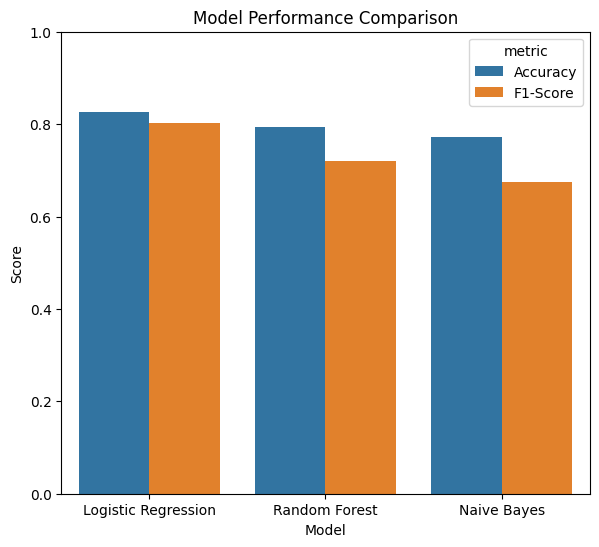

In [30]:
# Perform tuning for all models
results = [tune_and_evaluate((name, config)) for name, config in hyperparams.items()]
results_df = pd.DataFrame(results)

# Visualization
plt.figure(figsize=(15, 6))

# Accuracy and F1-Score
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='value', hue='metric', 
            data=pd.melt(results_df, id_vars=['Model'], 
                        value_vars=['Accuracy', 'F1-Score'],
                        var_name='metric'))
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


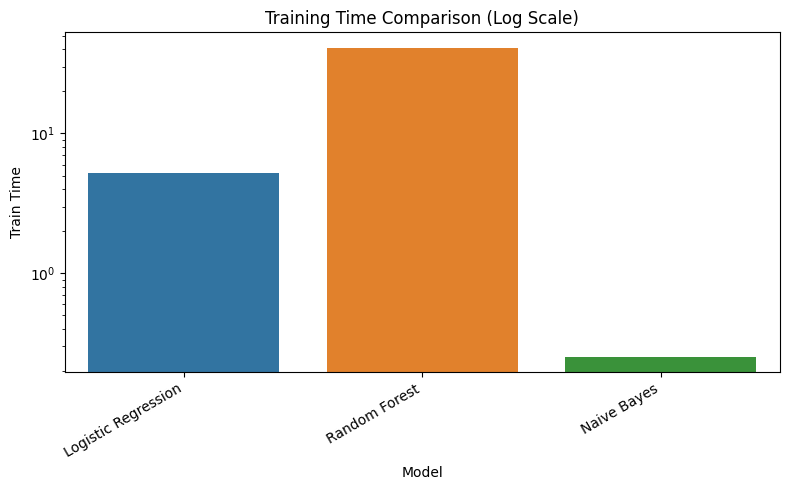

In [35]:
plt.figure(figsize=(8, 5))  # Wider figure for space
sns.barplot(x='Model', y='Train Time', data=results_df)
plt.title('Training Time Comparison (Log Scale)')
plt.yscale('log')
plt.xticks(rotation=30, ha='right')  # Rotate labels for readability
plt.tight_layout()
plt.show()


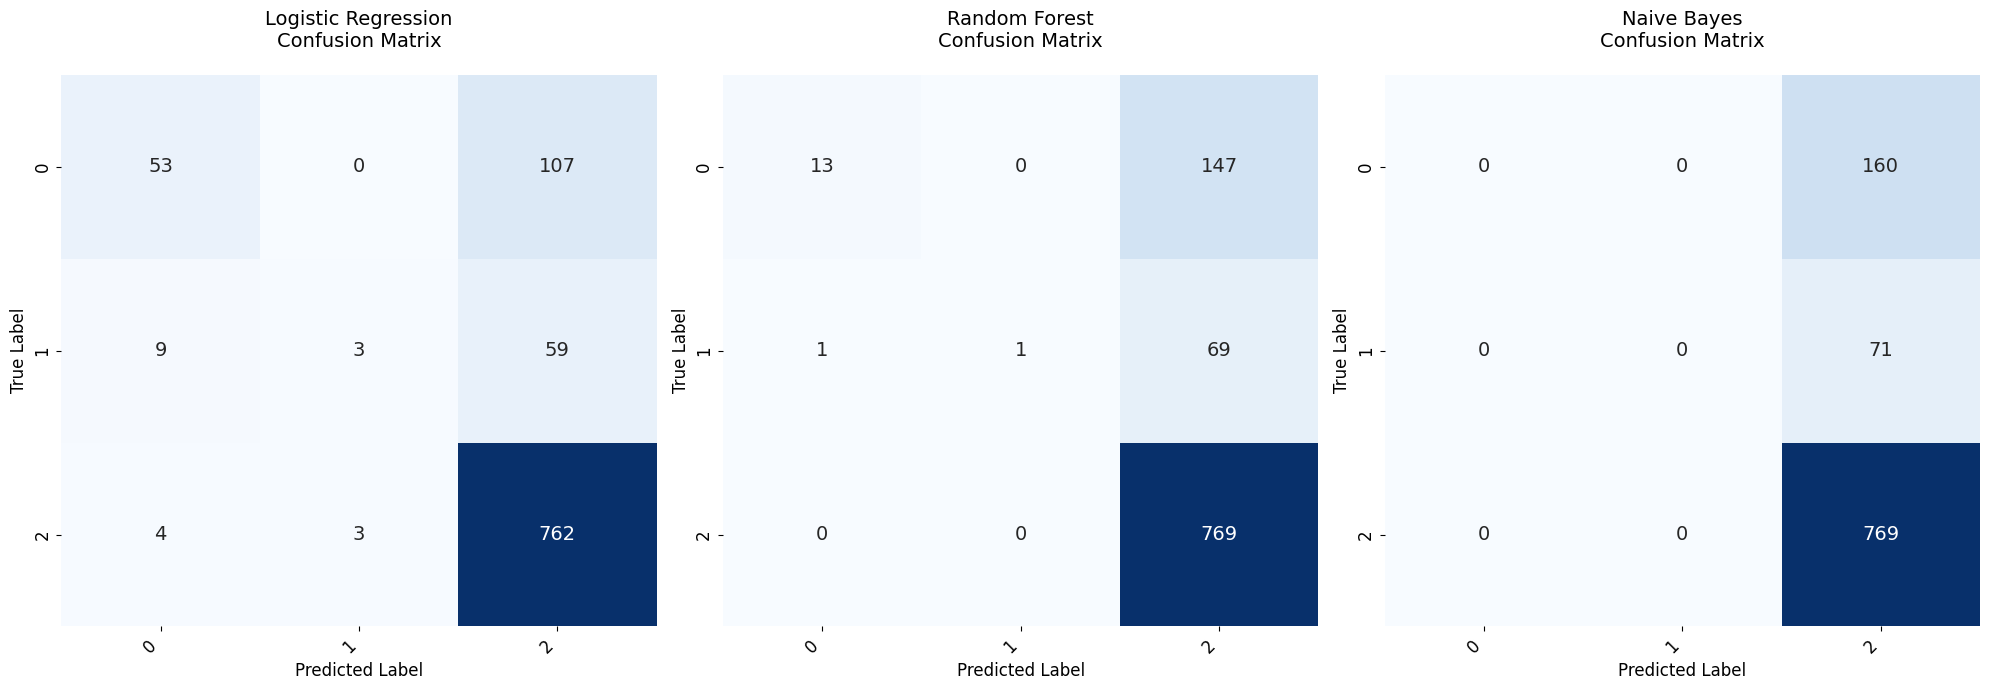

In [38]:
# Confusion Matrices with Improved Visualization
plt.figure(figsize=(20, 7))  # Increased figure size
for idx, model in enumerate(results):
    plt.subplot(1, 3, idx+1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, hyperparams[model['Model']]['model']
                          .fit(X_train_tfidf, y_train)
                          .predict(X_test_tfidf))
    
    # Create heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                annot_kws={"size": 14},  # Larger annotation text
                cbar=False)
    
    # Add labels and title
    plt.title(f"{model['Model']}\nConfusion Matrix", fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.3)  # Add space between subplots
plt.tight_layout()
plt.show()


In [33]:
# Model Selection using Composite Score
weights = {'Accuracy': 0.4, 'F1-Score': 0.4, 'Train Time': 0.2}
max_time = results_df['Train Time'].max()

results_df['Composite Score'] = (
    results_df['Accuracy'] * weights['Accuracy'] +
    results_df['F1-Score'] * weights['F1-Score'] +
    (1 - results_df['Train Time']/max_time) * weights['Train Time']
)

In [34]:
# Final Results
print("\n=== Tuning Results ===")
print(results_df[['Model', 'Accuracy', 'F1-Score', 'Train Time', 'Best Params']])
print("\n=== Best Model ===")
best_model = results_df.loc[results_df['Composite Score'].idxmax()]
print(f"Selected Model: {best_model['Model']}")
print(f"Composite Score: {best_model['Composite Score']:.3f}")
print(f"Accuracy: {best_model['Accuracy']:.3f}, F1-Score: {best_model['F1-Score']:.3f}")
print(f"Training Time: {best_model['Train Time']:.1f}s")


=== Tuning Results ===
                 Model  Accuracy  F1-Score  Train Time  \
0  Logistic Regression     0.827  0.802581    5.242360   
1        Random Forest     0.793  0.720684   41.011486   
2          Naive Bayes     0.772  0.675608    0.253535   

                                         Best Params  
0                       {'C': 10, 'solver': 'lbfgs'}  
1  {'max_depth': None, 'min_samples_split': 2, 'n...  
2                                     {'alpha': 0.5}  

=== Best Model ===
Selected Model: Logistic Regression
Composite Score: 0.826
Accuracy: 0.827, F1-Score: 0.803
Training Time: 5.2s
